<a href="https://colab.research.google.com/github/lipecamara/portifolio/blob/main/Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import xgboost as xgb
from sklearn.feature_selection import RFE, RFECV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
import joblib

In [ ]:
# https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

df = pd.read_csv('/content/loan_data.csv')

In [ ]:
df.columns = ['idade', 'genero', 'escolaridade', 'renda', 'exp_trab', 'tipo_moradia', 'valor_solicitado', 'motivo_emprestimo', 'taxa_juros',
              'renda_comprometida', 'his_cred_anos', 'score', 'inadimplencias_anteriores', 'situacao']

In [ ]:
df['genero'] = df.genero.map({'female': 'mulher', 'male':'homem'})
df['escolaridade'] = df['escolaridade'].map({'Master':'Mestrado', 'High School': 'Ensino Médio', 'Bachelor': 'Bacharelado', 'Associate': 'Associado', 'Doctorate': 'Doutorado'})
df['tipo_moradia'] = df['tipo_moradia'].map({'RENT': 'Aluguel', 'OWN':'Próprio', 'MORTGAGE':'Hipoteca', 'OTHER':'Outro'})
df['motivo_emprestimo'] = df['motivo_emprestimo'].map({'PERSONAL':'Pessoal', 'EDUCATION':'Educação', 'MEDICAL':'Saúde', 'VENTURE': 'Empréstimo de risco', 'HOMEIMPROVEMENT':'Reforma residencial',
       'DEBTCONSOLIDATION': 'Consolidação de dívidas'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   idade                      45000 non-null  float64
 1   genero                     45000 non-null  object 
 2   escolaridade               45000 non-null  object 
 3   renda                      45000 non-null  float64
 4   exp_trab                   45000 non-null  int64  
 5   tipo_moradia               45000 non-null  object 
 6   valor_solicitado           45000 non-null  float64
 7   motivo_emprestimo          45000 non-null  object 
 8   taxa_juros                 45000 non-null  float64
 9   renda_comprometida         45000 non-null  float64
 10  his_cred_anos              45000 non-null  float64
 11  score                      45000 non-null  int64  
 12  inadimplencias_anteriores  45000 non-null  object 
 13  situacao                   45000 non-null  int

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.idade.describe()

,idade
count,45000.000000
mean,27.764178
std,6.045108
min,20.000000
25%,24.000000
50%,26.000000
75%,30.000000
max,144.000000


In [ ]:
df = df[df['idade'] < 100]
df.reset_index(inplace=True, drop=True)

In [ ]:
X = df.drop('situacao', axis = 1)
y = df['situacao']

In [ ]:
colunas = X.columns

one_hot = make_column_transformer((OneHotEncoder(drop='if_binary'),
 ['genero', 'escolaridade', 'tipo_moradia', 'motivo_emprestimo', 'inadimplencias_anteriores']),
                                  remainder = 'passthrough', sparse_threshold=0)

In [ ]:
X = one_hot.fit_transform(X)

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, stratify=y, random_state=40)

In [ ]:
# modelo dummy para comparação

dummy = DummyClassifier()
dummy.fit(X_treino, y_treino)
dummy.score(X_teste, y_teste)

0.777758022935372

In [ ]:
def intervalo_confianca(cv_resultado):
  media = cv_resultado.mean()
  desvio_padrao = cv_resultado.std()
  print(f'Intervalo de Confiança: [{media - 2 * desvio_padrao} - {media + 2 * desvio_padrao}]')

In [ ]:
# modelo árvore de decisão

grid_parametros_arvore = {
    'criterion':  ['gini', 'entropy'],
    'max_depth': np.arange(1, 10),
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
arvore = DecisionTreeClassifier(random_state=40)
arvore_gs = GridSearchCV(estimator = arvore,
                         param_grid=grid_parametros_arvore,
                         scoring = 'recall',
                         n_jobs = -1,
                         cv = cv)
arvore_gs.fit(X_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=40), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='recall')

In [ ]:
arvore_gs.best_params_

{'criterion': 'gini',
 'max_depth': np.int64(3),
 'max_features': 'sqrt',
 'splitter': 'random'}

In [ ]:
parametros = arvore_gs.best_params_

rfecv = RFECV(estimator=DecisionTreeClassifier(random_state=40, **parametros),
              step = 1,
              cv = cv,
              scoring='recall',
              )
rfecv.fit(X_treino, y_treino)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
      estimator=DecisionTreeClassifier(max_depth=np.int64(3),
                                       max_features='sqrt', random_state=40,
                                       splitter='random'),
      scoring='recall')

In [ ]:
print('Número ideal de features: ', rfecv.n_features_)

Número ideal de features:  25


In [ ]:
selecionador = RFE(estimator=DecisionTreeClassifier(random_state=40, **parametros), n_features_to_select=25, step=1)
selecionador.fit(X_treino, y_treino)
X_treino_selecionado = selecionador.transform(X_treino)
X_teste_selecionado = selecionador.transform(X_teste)

In [ ]:
arvore = DecisionTreeClassifier(**parametros, random_state=40)
cv_resultado = cross_validate(arvore, X_treino_selecionado, y_treino, cv = cv, scoring = ['accuracy', 'recall'])

In [ ]:
cv_resultado

{'fit_time': array([0.04399848, 0.02188993, 0.01758742, 0.02028894, 0.02446604]),
 'score_time': array([0.00829482, 0.00800681, 0.00829458, 0.00848866, 0.00816393]),
 'test_accuracy': array([0.83093792, 0.81463921, 0.83241962, 0.82323307, 0.8245406 ]),
 'test_recall': array([0.79133333, 0.728     , 0.77533333, 0.74266667, 0.756     ])}

In [ ]:
intervalo_confianca(cv_resultado['test_accuracy'])

Intervalo de Confiança: [0.8124774903596617 - 0.8378306762193648]


In [ ]:
intervalo_confianca(cv_resultado['test_recall'])

Intervalo de Confiança: [0.7135140858372659 - 0.8038192474960673]


In [ ]:
arvore = DecisionTreeClassifier(**parametros, random_state = 40)
arvore.fit(X_treino_selecionado, y_treino)
y_pred = arvore.predict(X_teste_selecionado)
print('Acurácia de treino: ', arvore.score(X_treino_selecionado, y_treino))
print('Acurácia de teste: ', arvore.score(X_teste_selecionado, y_teste))

Acurácia de treino:  0.8252726410621147
Acurácia de teste:  0.8202506889501289


              precision    recall  f1-score   support

           0       0.93      0.84      0.88      8749
           1       0.57      0.76      0.65      2500

    accuracy                           0.82     11249
   macro avg       0.75      0.80      0.77     11249
weighted avg       0.85      0.82      0.83     11249



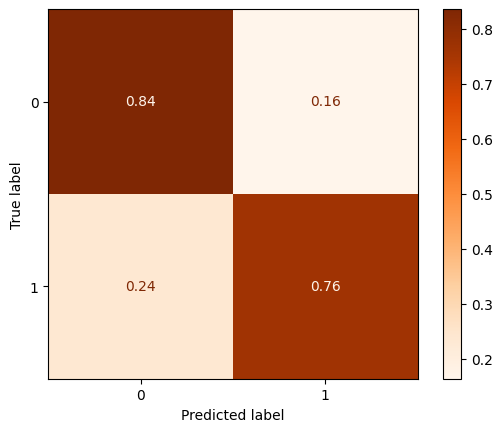

In [ ]:
print(classification_report(y_teste, y_pred))
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred, normalize='true', cmap = 'Oranges');

In [ ]:
# modelo árvore de decisão com oversampling

pipeline = imbpipeline([('oversample', SMOTE()), ('arvore', DecisionTreeClassifier(random_state=40))])

grid_parametros_arvore = {
    'arvore__criterion':  ['gini', 'entropy'],
    'arvore__max_depth': np.arange(1, 10),
    'arvore__max_features': ['sqrt', 'log2'],
    'arvore__splitter': ['best', 'random']
}

arvore_smote_gs = GridSearchCV(estimator = pipeline,
                         param_grid=grid_parametros_arvore,
                         scoring = 'recall',
                         n_jobs = -1,
                         cv = cv)
arvore_smote_gs.fit(X_treino, y_treino)
arvore_smote_gs.best_params_

{'arvore__criterion': 'entropy',
 'arvore__max_depth': np.int64(5),
 'arvore__max_features': 'log2',
 'arvore__splitter': 'random'}

In [ ]:
parametros = {'criterion': 'gini',
 'max_depth': np.int64(5),
 'max_features': 'log2',
 'splitter': 'random'}

pipeline = imbpipeline([('oversample', SMOTE()), ('arvore', DecisionTreeClassifier(random_state=40, **parametros))])
cv_resultado = cross_validate(pipeline, X_treino, y_treino, cv = cv, scoring = ['accuracy', 'recall'])

In [ ]:
cv_resultado

{'fit_time': array([0.27686453, 0.29632187, 0.28319263, 0.27754211, 0.27999163]),
 'score_time': array([0.00624418, 0.00603986, 0.00623083, 0.00603652, 0.00679708]),
 'test_accuracy': array([0.7567047 , 0.54452511, 0.75729738, 0.74870351, 0.75874333]),
 'test_recall': array([0.97133333, 0.95266667, 0.97333333, 0.97466667, 0.97333333])}

In [ ]:
intervalo_confianca(cv_resultado['test_accuracy'])

Intervalo de Confiança: [0.5443797633336691 - 0.8820098495471345]


In [ ]:
intervalo_confianca(cv_resultado['test_recall'])

Intervalo de Confiança: [0.9525290328173721 - 0.9856043005159614]


              precision    recall  f1-score   support

           0       0.99      0.68      0.81      8749
           1       0.47      0.98      0.63      2500

    accuracy                           0.75     11249
   macro avg       0.73      0.83      0.72     11249
weighted avg       0.87      0.75      0.77     11249



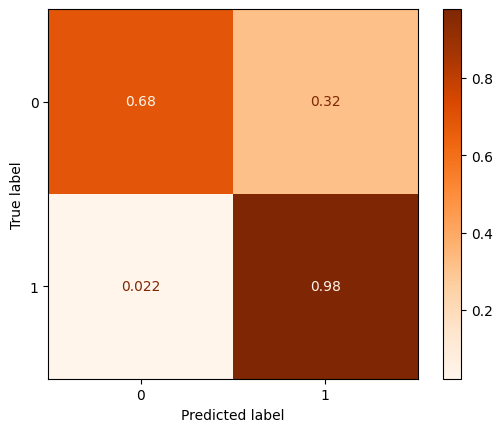

In [ ]:
arvore = DecisionTreeClassifier(**parametros, random_state = 40)
oversample = SMOTE()
X_treino_balanceado, y_treino_balanceado = oversample.fit_resample(X_treino, y_treino)
arvore.fit(X_treino_balanceado, y_treino_balanceado)
y_pred = arvore.predict(X_teste)
print(classification_report(y_teste, y_pred))
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred, normalize='true', cmap = 'Oranges');

In [ ]:
# modelo Logistic Regression

max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

parametros_rl = [
    {'logisticregression__solver' : ['newton-cg', 'lbfgs'],
      'logisticregression__penalty' : ['l2'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c},
    {'logisticregression__solver' : ['liblinear'],
      'logisticregression__penalty' : ['l1', 'l2'],
      'logisticregression__max_iter' : max_iter,
      'logisticregression__C' : c},
]

gs_log_reg = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression(random_state=40)),
                     param_grid=parametros_rl,
                     scoring = 'recall',
                     n_jobs=-1,
                     cv = cv)
gs_log_reg.fit(X_treino, y_treino)
gs_log_reg.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': np.int64(100),
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [ ]:
parametros = {'C': 0.001,
 'max_iter': np.int64(100),
 'penalty': 'l2',
 'solver': 'liblinear'}

normalizacao = StandardScaler()

X_treino_normalizado = normalizacao.fit_transform(X_treino)

modelo_log_reg = LogisticRegression(random_state=40, **parametros)

rfecv = RFECV(estimator=modelo_log_reg,
              step = 1,
              cv = cv,
              scoring='recall',
              )
rfecv.fit(X_treino_normalizado, y_treino)
print('Número ideal de features: ', rfecv.n_features_)

Número ideal de features:  22


In [ ]:
X_teste_normalizado = normalizacao.fit_transform(X_teste)

selecionador = RFE(estimator = modelo_log_reg, n_features_to_select=22, step=1)
selecionador.fit(X_treino_normalizado, y_treino)
X_treino_normalizado_selecionado = selecionador.transform(X_treino_normalizado)
X_teste_normalizado_selecionado = selecionador.transform(X_teste_normalizado)

In [ ]:
modelo_log_reg = LogisticRegression(random_state=40, **parametros)
cv_resultado = cross_validate(modelo_log_reg, X_treino_normalizado_selecionado, y_treino, cv = cv, scoring = ['accuracy', 'recall'])

In [ ]:
intervalo_confianca(cv_resultado['test_accuracy'])

Intervalo de Confiança: [0.8849984936021554 - 0.9016899117055138]


In [ ]:
intervalo_confianca(cv_resultado['test_recall'])

Intervalo de Confiança: [0.7237687231454405 - 0.7804979435212261]


              precision    recall  f1-score   support

           0       0.93      0.94      0.93      8749
           1       0.77      0.74      0.76      2500

    accuracy                           0.89     11249
   macro avg       0.85      0.84      0.84     11249
weighted avg       0.89      0.89      0.89     11249



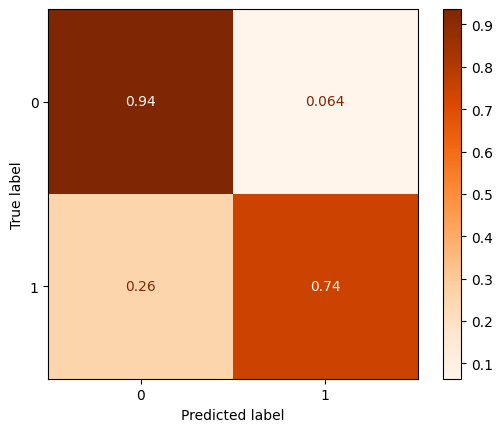

In [ ]:
modelo_log_reg = LogisticRegression(random_state=40, **parametros)
modelo_log_reg.fit(X_treino_normalizado_selecionado, y_treino)
y_pred = modelo_log_reg.predict(X_teste_normalizado_selecionado)
print(classification_report(y_teste, y_pred))
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred, normalize='true', cmap = 'Oranges');

In [ ]:
# modelo Logistic Regression com oversampling

max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

parametros_lr = [
    {'lr__solver' : ['newton-cg', 'lbfgs'],
      'lr__penalty' : ['l2'],
      'lr__max_iter' : max_iter,
       'lr__C' : c},
    {'lr__solver' : ['liblinear'],
      'lr__penalty' : ['l1', 'l2'],
      'lr__max_iter' : max_iter,
      'lr__C' : c},
]

pipeline = imbpipeline([('oversample', SMOTE()), ('normalizacao', StandardScaler()), ('lr', LogisticRegression(random_state=40))])

gs_log_reg_smote = GridSearchCV(estimator=pipeline,
                     param_grid=parametros_lr,
                     scoring = 'recall',
                     n_jobs=-1,
                     cv = cv)
gs_log_reg_smote.fit(X_treino, y_treino)
gs_log_reg_smote.best_params_

{'lr__C': 0.001,
 'lr__max_iter': np.int64(150),
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [ ]:
parametros = {'C': 0.001,
 'max_iter': np.int64(150),
 'penalty': 'l1',
 'solver': 'liblinear'}

oversample = SMOTE()
X_treino_balanceado, y_treino_balanceado = oversample.fit_resample(X_treino, y_treino)

normalizacao = StandardScaler()
X_treino_balanceado_normalizado = normalizacao.fit_transform(X_treino_balanceado)

modelo_log_reg = LogisticRegression(random_state=40, **parametros)

rfecv = RFECV(estimator=modelo_log_reg,
              step = 1,
              cv = cv,
              scoring='recall',
              )
rfecv.fit(X_treino_balanceado_normalizado, y_treino_balanceado)
print('Número ideal de features: ', rfecv.n_features_)

Número ideal de features:  1


In [ ]:
X_teste_normalizado = normalizacao.fit_transform(X_teste)

selecionador = RFE(estimator = modelo_log_reg, n_features_to_select=1, step=1)
selecionador.fit(X_treino_balanceado_normalizado, y_treino_balanceado)

X_treino_balanceado_normalizado_selecionado = selecionador.transform(X_treino_balanceado_normalizado)
X_teste_normalizado_selecionado = selecionador.transform(X_teste_normalizado)

In [ ]:
modelo_log_reg = LogisticRegression(random_state=40, **parametros)
cv_resultado = cross_validate(modelo_log_reg, X_treino_normalizado_selecionado, y_treino, cv = cv, scoring = ['accuracy', 'recall'])

In [ ]:
intervalo_confianca(cv_resultado['test_accuracy'])

Intervalo de Confiança: [0.8751964063591795 - 0.8900955251860592]


In [ ]:
intervalo_confianca(cv_resultado['test_recall'])

Intervalo de Confiança: [0.6322554245418384 - 0.6765445754581618]


              precision    recall  f1-score   support

           0       1.00      0.65      0.79      8749
           1       0.45      1.00      0.62      2500

    accuracy                           0.73     11249
   macro avg       0.72      0.82      0.70     11249
weighted avg       0.88      0.73      0.75     11249



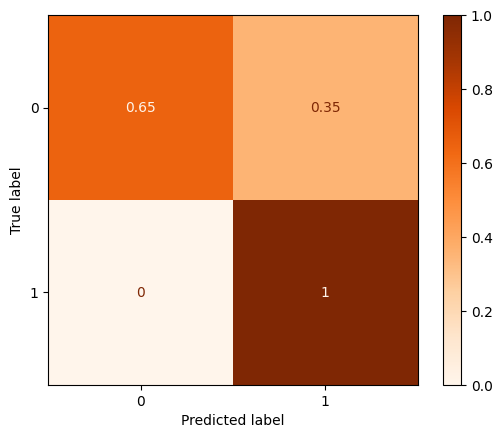

In [ ]:
modelo_log_reg = LogisticRegression(random_state=40, **parametros)
modelo_log_reg.fit(X_treino_balanceado_normalizado_selecionado, y_treino_balanceado)
y_pred = modelo_log_reg.predict(X_teste_normalizado_selecionado)
print(classification_report(y_teste, y_pred))
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred, normalize='true', cmap = 'Oranges');

In [ ]:
# modelo XGBoost

parametros = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [0, 2, 4, 6, 10],
    'colsample_bytree': [0.1, 0.5, 1],
    'n_estimators': [10, 25, 50]
}

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=40)

modelo_xgb = xgb.XGBClassifier(objective='binary:logistic')
gs_xgb = GridSearchCV(estimator = modelo_xgb, param_grid = parametros, cv = cv, scoring = 'recall', verbose = 1)
gs_xgb.fit(X_treino, y_treino)
print('Melhores parâmetros', gs_xgb.best_params_)
print('Best score: ', gs_xgb.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Melhores parâmetros {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50}
Best score:  0.8006666666666667


In [ ]:
parametros = gs_xgb.best_params_

dmatrix = xgb.DMatrix(data=X, label=y)

cv_resultados = xgb.cv(dtrain=dmatrix, params=parametros, nfold=3, num_boost_round=100, early_stopping_rounds=5,
                       metrics='error', as_pandas=True, seed=123)

acuracia = 1 - cv_resultados['test-error-mean'].iloc[-1]
print(f'Acuracia: {acuracia}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Acuracia: 0.9280998826189502


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      8749
           1       0.89      0.79      0.84      2500

    accuracy                           0.93     11249
   macro avg       0.92      0.88      0.90     11249
weighted avg       0.93      0.93      0.93     11249



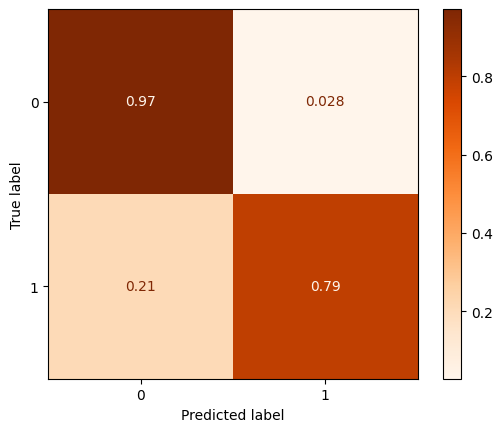

In [ ]:
modelo_xgb = xgb.XGBClassifier(objective='binary:logistic', **parametros)
modelo_xgb.fit(X_treino, y_treino)
y_pred = modelo_xgb.predict(X_teste)
print(classification_report(y_teste, y_pred))
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred, normalize='true', cmap = 'Oranges');

In [ ]:
# modelo XGBoost com oversample

parametros = {
    'xgb__learning_rate': [0.1, 0.2, 0.3],
    'xgb__max_depth': [0, 2, 4, 6, 10],
    'xgb__colsample_bytree': [0.1, 0.5, 1],
    'xgb__n_estimators': [10, 25, 50]
}

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=40)

modelo_xgb_smote = xgb.XGBClassifier(objective='binary:logistic')
pipeline = imbpipeline([('oversample', SMOTE()), ('xgb', modelo_xgb_smote)])

gs_xgb = GridSearchCV(estimator = pipeline, param_grid = parametros, cv = cv, scoring = 'recall', verbose = 1)
gs_xgb.fit(X_treino, y_treino)
print('Melhores parâmetros', gs_xgb.best_params_)
print('Best score: ', gs_xgb.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Melhores parâmetros {'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 2, 'xgb__n_estimators': 10}
Best score:  0.9428000000000001


In [ ]:
parametros = {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 10}

cv_resultados = xgb.cv(dtrain=dmatrix, params=parametros, nfold=3, num_boost_round=100, early_stopping_rounds=5,
                       metrics='error', as_pandas=True, seed=123)

acuracia = 1 - cv_resultados['test-error-mean'].iloc[-1]
print(f'Acuracia: {acuracia}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Acuracia: 0.9100970747556633


              precision    recall  f1-score   support

           0       0.98      0.76      0.86      8749
           1       0.53      0.94      0.68      2500

    accuracy                           0.80     11249
   macro avg       0.75      0.85      0.77     11249
weighted avg       0.88      0.80      0.82     11249



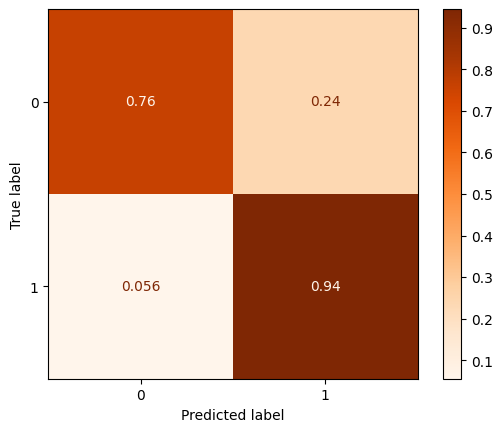

In [ ]:
modelo_xgb = xgb.XGBClassifier(objective='binary:logistic', **parametros)
oversample = SMOTE()
X_treino_balanceado, y_treino_balanceado = oversample.fit_resample(X_treino, y_treino)
modelo_xgb.fit(X_treino_balanceado, y_treino_balanceado)
y_pred = modelo_xgb.predict(X_teste)
print(classification_report(y_teste, y_pred))
ConfusionMatrixDisplay.from_predictions(y_teste, y_pred, normalize='true', cmap = 'Oranges');

In [ ]:
# modelo selecionado: XGBoost sem oversampling

modelo_final = xgb.XGBClassifier(objective='binary:logistic', **parametros)
modelo_final.fit(X, y)
joblib.dump(modelo_final, 'modelo_xgb.pkl')

['modelo_xgb.pkl']